# Feature Analysis

In [1]:
import pandas as pd

In [2]:
filename1 = 'pionminus'
filename2 = 'electron'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

In [3]:
data1 = pd.read_csv(filepath+f'{filename1}.csv')
data1.loc[data1['phi0'] > -99, 'phi0'] = 0
data2 = pd.read_csv(filepath+f'{filename2}.csv')
data2.loc[data2['phi0'] > -99, 'phi0'] = 1

In [4]:
data = pd.concat([data1,data2], sort=False)
data = data.sample(frac = 1)
data['phi0'] = data['phi0'].astype('int32')
data['centrality'] = data['centrality'].astype('int32')
data['zvertex'] = data['zvertex'].astype('float16')
data['pt'] = data['pt'].astype('float16')
data['e/p'] = data['e/p'].astype('float16')
data['n0'] = data['n0'].astype('int32')
data['disp'] = data['disp'].astype('float16')
data['chi2'] = data['chi2'].astype('float16')
data['npe0'] = data['npe0'].astype('int32')
data['prob'] = data['prob'].astype('float16')
data.head()

,centrality,zvertex,pt,e/p,n0,disp,chi2,npe0,prob,phi0
256973,9,9.046875,0.942871,1.023438,1,8.257812,36.343750,3,0.000541,0
1170800,28,1.573242,0.418213,0.685059,5,4.109375,52.312500,9,0.656250,1
223282,21,-1.007812,1.045898,1.145508,2,4.140625,162.625000,4,0.001450,1
53835,20,4.117188,0.694336,0.831055,4,2.285156,27.250000,6,0.000610,1
511559,23,4.617188,1.004883,0.898926,3,5.617188,15.609375,7,0.870605,1


In [5]:
print(data.size, data.shape, data1.shape, data2.shape)

20743310 (2074331, 10) (348012, 10) (1726319, 10)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)



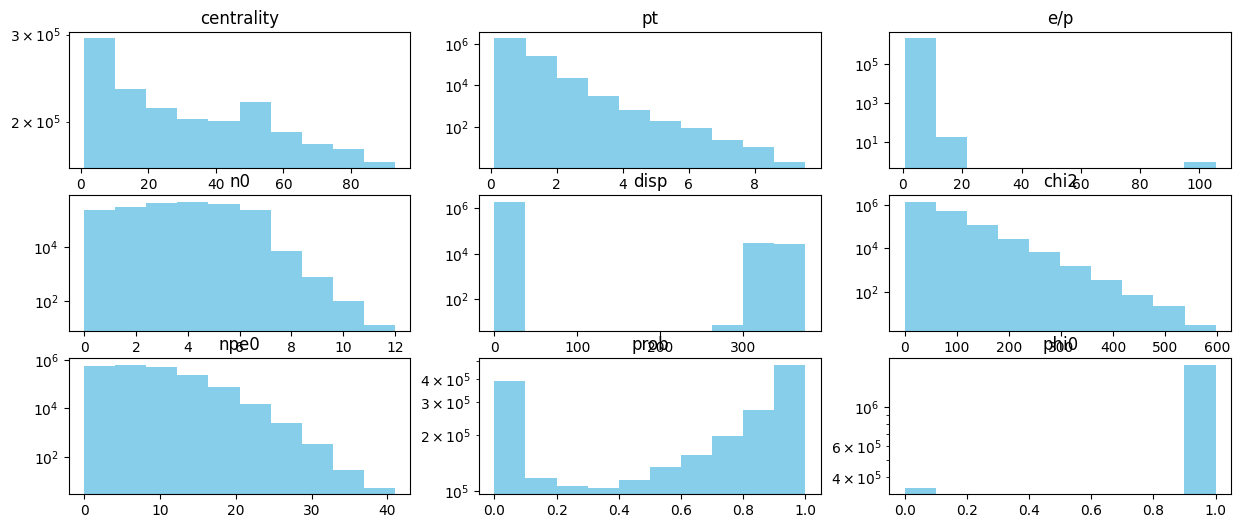

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
from sklearn.preprocessing import OneHotEncoder

def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # удаляем impressions
    data = data.drop('impressions', axis = 1)
    
    # создаем фичи от времени
    data.date_time = pd.to_datetime(data.date_time)
    data['day'] = data['date_time'].dt.weekday
    data['hour'] = data['date_time'].dt.hour
    
    # строим графики зависимости количества кликов от дня недели и часа
    data[data['clicks'] > 0].sort_values(by = ['day']).groupby(['day'])['clicks'].sum().plot.barh(title='Clicks by weekday')
    plt.show()
    data[data['clicks'] > 0].sort_values(by = ['hour']).groupby(['hour'])['clicks'].sum().plot.barh(title='Clicks by hour')

    # добавляем интерсекции между часом и днем недели 
    data['hour_day'] = data['day'].astype(str) + ' ' + data['hour'].astype(str)
    data['hour_day'] = pd.factorize(data['hour_day'])[0]
    
    # выделяем редкие zone id в категорию -1
    zone_id_counts = data['zone_id'].value_counts()
    idxs = zone_id_counts[zone_id_counts < 10].index
    
    data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1
    
    # выделяем редкие os_id в категорию 7
    data.loc[data['os_id'] > 7, 'os_id'] = 7
    
    # преобразовываем campaign clicks в бинарную фичу
    data['before_clicks'] = data['campaign_clicks'] > 0
    data['before_clicks'] = data['before_clicks'].astype('int64')
    
    # делим выборку на train и test
    data = data.sort_values(by='date_time', ignore_index=True)
    cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    y = data['clicks']
    data = data.drop(columns = ['banner_id', 'clicks', 'campaign_clicks', 'date_time'])
    data_train, data_test = data.iloc[:cut_off_test, :], data.iloc[cut_off_test:, :]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    enc.fit(data_train)
    transformed_train = enc.transform(data_train)
    transformed_test = enc.transform(data_test)
    
    return transformed_train, transformed_test, y_train, y_test,cut_off_val

In [10]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [11]:
transformed_train_all, transformed_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

691443 1382888


In [12]:
transformed_test

,centrality,pt,e/p,n0,disp,chi2,npe0,prob
373204,6,0.625000,0.815430,3,3.593750,136.750000,4,0.952637
326607,19,0.658203,0.612793,0,345.750000,52.687500,0,0.027756
261635,64,0.961426,0.933105,5,1.006836,32.531250,9,0.960938
61522,50,0.560547,0.908691,5,2.447266,21.984375,7,0.450684
12262,31,0.400879,0.676270,1,5.472656,24.437500,1,0.784180
...,...,...,...,...,...,...,...,...
1667774,78,0.347900,1.000977,3,6.203125,37.187500,7,0.918945
59699,65,0.825684,0.620605,1,7.128906,3.681641,2,0.131592
838338,27,0.730469,0.789062,2,4.687500,34.531250,1,0.121094
1448418,92,0.375732,1.108398,5,3.851562,27.250000,13,0.426514


In [13]:
transformed_train, transformed_val = transformed_train_all[:cut_off_val], transformed_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, f1_score

In [15]:
def create_model(C):
    clf = LogisticRegression(solver='newton-cholesky', max_iter=10000, C=C, verbose=1)
    return clf

Возьмем логистическую регрессию, в качестве солвера берем newton-cholesky, так как в документации sklearn сказано, что он лучше работает с one-hot-encoded фичами.

# Cross Validation

In [16]:
def cv(data_train: pd.DataFrame, data_val, y_train, y_val):
    best_score = 0.5
    best_C = 0.1
    for C in [0.001,0.01,0.02,0.04,0.08,0.12,1,100]:
        clf = create_model(C)
        clf.fit(data_train, y_train)
        y_pred_probs = clf.predict_proba(data_val)
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        if score > best_score:
            best_score = score
            best_C = C
            print("localy best C:", best_C)       
    print("the best C:", best_C)        
    best_model = create_model(best_C)
    return best_model

In [17]:
print(transformed_val.shape,y_val.shape)

(691445, 8) (691445,)


In [18]:
clf = cv(transformed_train, transformed_val, y_train, y_val)

Newton iter=1
  Check Convergence
    1. max |gradient| 3.753626074287549 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 1.3094159915712942 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.3857805190820564 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.06686046125434526 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.0025427575880397147 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 3.5267816355673298e-06 <= 0.0001
    2. Newton decrement 1.0042413273191016e-07 <= 0.0001
  Solver did converge at loss = 0.24070189551038146.
localy best C: 0.001
Newton iter=1
  Check Convergence
    1. max |gradient| 3.7690862048995846 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 1.329346157033131 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.4002473820070786 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0733079362455122 <= 0.0001
Newton iter=5

Обучаем лучшую модель заново на тренировочном и валидационном датасете.

In [19]:
clf.fit(transformed_train_all, y_train_all)

Newton iter=1
  Check Convergence
    1. max |gradient| 3.7672868928126975 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 1.3310966677779095 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.4034144811717642 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.07471821159399437 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.003372270711231343 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 6.728944441980426e-06 <= 0.0001
    2. Newton decrement 1.9954231836921432e-07 <= 0.0001
  Solver did converge at loss = 0.23584439826346093.


LogisticRegression(C=1, max_iter=10000, solver='newton-cholesky', verbose=1)

# Model Evaluation

In [20]:
y_pred_probs = clf.predict_proba(transformed_test)
y_pred = clf.predict(transformed_test)

In [21]:
clf

LogisticRegression(C=1, max_iter=10000, solver='newton-cholesky', verbose=1)

Посчитаем скоры (ROC AUC, log loss и f1 score).

log loss: 0.23713855327103647
roc auc: 0.9268571705326659
f1 score: 0.9076297968397291


Text(0.5, 1.0, 'ROC AUC Curve')

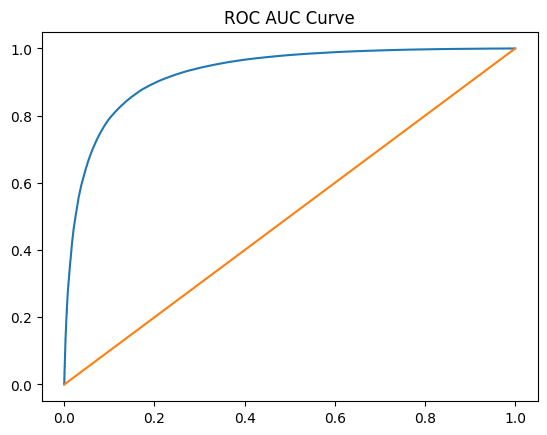

In [22]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

Сравним со скорами из бейзлайна. Бейзлайн: предсказываем все нулями

In [23]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.4521949906684736


Видим, что наша модель обгоняет бейзлайн по метрикам ROC AUC и Log Loss.

In [24]:
i = 7000
print(thresholds[i],fpr[i],tpr[i])
print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.9733476314341113 0.030600979783343682 0.5454622857728684
884.2116388091238 1621.0316677646733


In [25]:
print(clf.intercept_)
for keff in clf.coef_[0]:
    print(keff)
output_data = [clf.intercept_,clf.coef_[0]]
with open("output/keffs.txt", "w") as txt_file:
    for line in output_data:
        txt_file.write("".join(str(line)) + "\n")

[-4.93469044]
0.022776959213616225
0.734088106698924
0.8073512608719784
0.6718164197473536
-0.0009550409841210739
0.0018186067806632128
0.25078976466476377
2.4181887181965838


In [26]:
def answer(centrality,pt,ep,n0,disp,chi2,npe0,prob):
    ans = clf.coef_[0][0]*centrality+clf.coef_[0][1]*pt+clf.coef_[0][2]*ep+clf.coef_[0][3]*n0+\
        clf.coef_[0][4]*disp+clf.coef_[0][5]*chi2+clf.coef_[0][6]*npe0+clf.coef_[0][7]*prob+clf.intercept_[0]
    return ans

In [27]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.15089840542248636


In [29]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1
    if proba_loc[counter][1]>0.9727650435469417: 
        if phi0: AIcute+=1
        else: AIcuth+=1
    if phi0: norm_e+=1
    else: norm_h+=1
    if counter<10: 
        print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

[0.84910159 0.15089841] -1.7275720443616325
[0.02068408 0.97931592] 3.857490019987293
[0.53038048 0.46961952] -0.12167178589756755
[0.28042404 0.71957596] 0.9423592246982793
[0.04964728 0.95035272] 2.951889612273262
[0.78776083 0.21223917] -1.3114807145432072
[0.03408292 0.96591708] 3.344281471239948
[4.77921134e-04 9.99522079e-01] 7.645586794889021
[0.00295527 0.99704473] 5.821205561946363
[0.02774907 0.97225093] 3.5564116441023144


In [30]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

832182 167819 0.508 0.014 0.55 0.031 0.056 0.056
